# Assignment 2

The 2 experiments done in this assignment was walking up a set of straight stairs and walking down a set of straight stairs. The device was strapped on tightly to the inner ankle of the right foot for both the experiments to maintain consistency and reduce motion artefacts.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import dslab
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.transformers import FeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve,auc

%matplotlib inline

C:\Users\John\anaconda3\envs\term120x_env\python.exe
{'numpy': '1.19.1', 'pandas': '1.0.1', 'seaborn': '0.10.0', 'sklearn': '0.22.1', 'matplotlib': '3.1.3'}


In [2]:
walkup = pd.read_csv('walk_up_final.csv',index_col = 0,header = 1, names = ['ax','ay','az','|a|'],parse_dates = True)
walkdown = pd.read_csv('walk_down_final.csv',index_col = 0,header = 1, names = ['ax','ay','az','|a|'],parse_dates = True)

In [3]:
#making the index into datetime objects for use
walkup.index = pd.to_datetime(walkup.index, format= "%H:%M:%S:%f")
walkdown.index = pd.to_datetime(walkdown.index, format= "%H:%M:%S:%f")

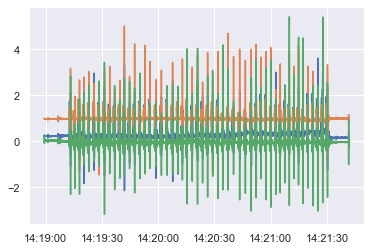

In [4]:
plt.plot(walkup['ax'])
plt.plot(walkup['ay'])
plt.plot(walkup['az'])

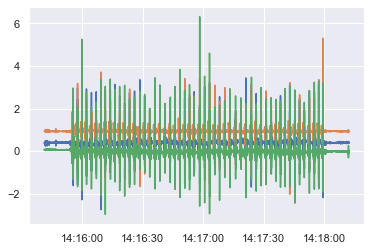

In [5]:
plt.plot(walkdown['ax'])
plt.plot(walkdown['ay'])
plt.plot(walkdown['az'])

Each of the raw data shows a similar pattern however, the acceleration in the y axis appears to have higher peaks in the walking up experiment as compared to the walking down experiment. The distance between each peak roughly indicates the time between each step. I have recorded baseline data at the start and the end of each activity to easily identify the transition times. 

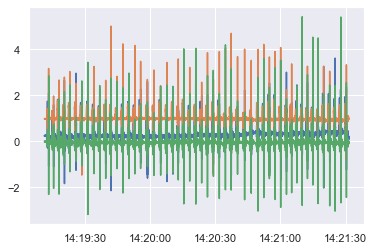

In [6]:
#pruning data by eyeball
walkup2 = walkup.iloc[6000:76000]
plt.plot(walkup2['ax'])
plt.plot(walkup2['ay'])
plt.plot(walkup2['az'])


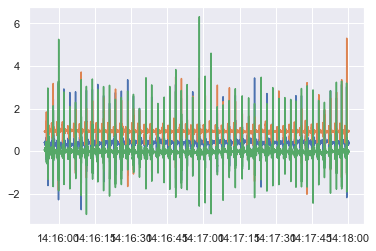

In [7]:
#pruning data by eyeball
walkdown2 = walkdown.iloc[6400:69500]
plt.plot(walkdown2['ax'])
plt.plot(walkdown2['ay'])
plt.plot(walkdown2['az'])

In [8]:
print(walkdown2['ay'].mean())
print(walkup2['ay'].mean())

0.8968285150554676
0.9533974942857142


In [9]:
walkup2['delta_t'] = walkup2.index - walkup2.index[0]
#walkup2.tail()


C:\Users\John\anaconda3\envs\term120x_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
walkdown2['delta_t'] = walkdown2.index - walkdown2.index[0]
#walkdown2.tail()

C:\Users\John\anaconda3\envs\term120x_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The length of activities after pruning is 2min and 20sec for walking up 2min and 6sec for walking down

In [11]:
idx = np.asarray(np.floor(walkup2.reset_index().index/100).values,np.int)
walkup2['window_idx'] = ['u{:03}'.format(i) for i in idx]


C:\Users\John\anaconda3\envs\term120x_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
idx = np.asarray(np.floor(walkdown2.reset_index().index/100).values,np.int)
walkdown2['window_idx'] = ['d{:03}'.format(i) for i in idx]


C:\Users\John\anaconda3\envs\term120x_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
print(walkup2.shape)
print(walkdown2.shape)

(70000, 6)
(63100, 6)


In [14]:
combined = pd.concat([walkup2,walkdown2])

In [15]:
print(walkup2.shape)
print(walkdown2.shape)
print(combined.shape)
#print(walkup2.groupby('window_idx').count())
#print(walkdown2.groupby('window_idx').count())

(70000, 6)
(63100, 6)
(133100, 6)


The shape of the walking up, walking down and combined is (73000,6) , (63100,6) and (133100,6) respectively.
A total of 1331 unique values of column window idx were generated with 700 in walk up and 631 in walk down


In [16]:
X = extract_features(combined, column_id='window_idx', column_sort='delta_t',
                    default_fc_parameters=ComprehensiveFCParameters())
X.shape

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [03:35<00:00, 10.79s/it]


(1331, 3036)

Shape of the feature extraction is (1331,3036). 3036 features have been extracted

In [17]:
a = [True] * 700
b = [False] *631
c = a+b
y = pd.Series(c,index = X.index,name = 'window_idx') 

In [18]:
select = FeatureSelector()

In [19]:
select.fit(X.dropna(axis=1),y)

FeatureSelector(chunksize=None, fdr_level=0.05, hypotheses_independent=False,
                ml_task='auto', n_jobs=4,
                test_for_binary_target_binary_feature='fisher',
                test_for_binary_target_real_feature='mann',
                test_for_real_target_binary_feature='mann',
                test_for_real_target_real_feature='kendall')

In [20]:
select.relevant_features

['ax__median',
 'ax__quantile__q_0.4',
 'ax__quantile__q_0.6',
 'ax__fft_coefficient__coeff_0__attr_"abs"',
 'ax__fft_coefficient__coeff_0__attr_"real"',
 'ax__mean',
 'ax__sum_values',
 'ax__quantile__q_0.3',
 'ax__quantile__q_0.7',
 'ax__abs_energy',
 'ax__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"',
 'ax__quantile__q_0.8',
 'ax__quantile__q_0.2',
 'ax__c3__lag_3',
 'ax__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
 'ax__c3__lag_2',
 'ax__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'ay__quantile__q_0.1',
 'ay__quantile__q_0.2',
 'ax__c3__lag_1',
 'ay__quantile__q_0.3',
 'ax__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'ax__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"',
 'ax__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"intercept"',
 'ax__linear_trend_timewise__attr_"intercept"',
 'ax__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"intercept"',
 'ax__linear_trend__attr_"intercept

In [21]:
p_values = pd.Series(select.p_values, index = select.features)
p_values[select.relevant_features]

ax__median                                                     6.104161e-44
ax__quantile__q_0.4                                            3.728689e-43
ax__quantile__q_0.6                                            4.823539e-42
ax__fft_coefficient__coeff_0__attr_"abs"                       1.715114e-41
ax__fft_coefficient__coeff_0__attr_"real"                      1.765687e-41
                                                                   ...     
az__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_10    8.332055e-04
az__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_10    8.357810e-04
ay__approximate_entropy__m_2__r_0.9                            8.448538e-04
az__longest_strike_below_mean                                  8.686258e-04
ax__number_cwt_peaks__n_1                                      8.817642e-04
Length: 317, dtype: float64

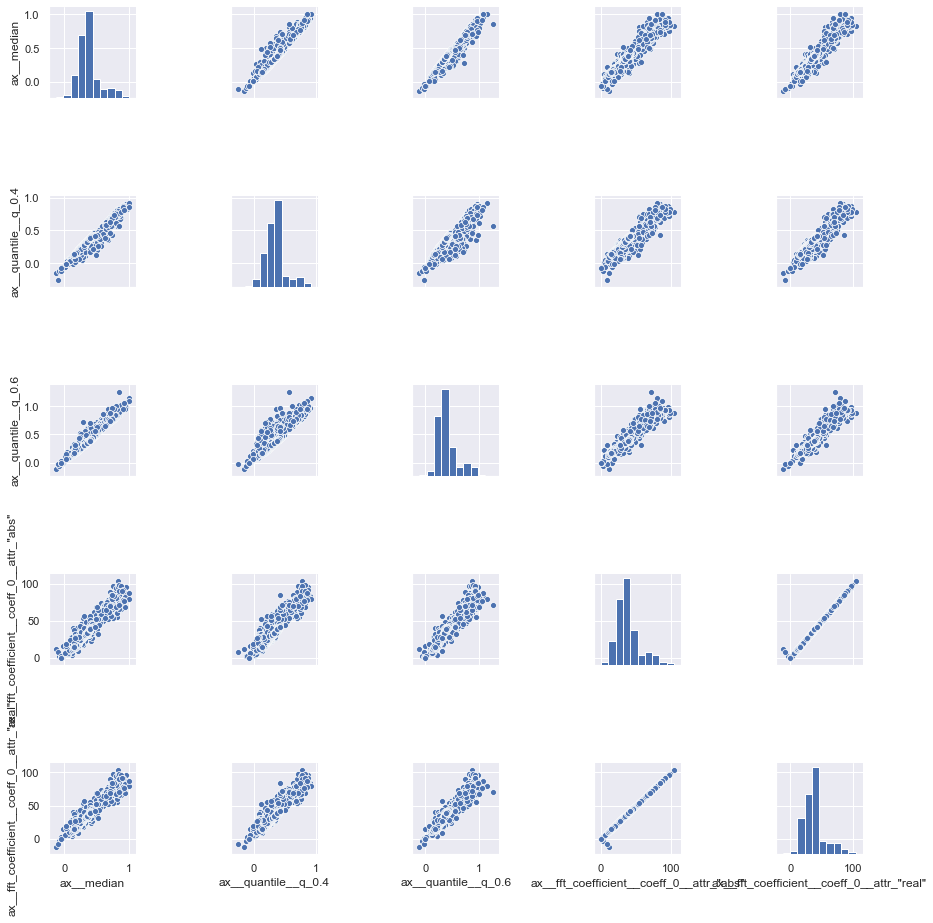

In [22]:
sns.pairplot(X,
                x_vars=["ax__median", "ax__quantile__q_0.4", 'ax__quantile__q_0.6','ax__fft_coefficient__coeff_0__attr_"abs"',
                        'ax__fft_coefficient__coeff_0__attr_"real"'],
             y_vars=["ax__median", "ax__quantile__q_0.4",'ax__quantile__q_0.6','ax__fft_coefficient__coeff_0__attr_"abs"',
                     'ax__fft_coefficient__coeff_0__attr_"real"'])

In [23]:
clf = RandomForestClassifier()
clf.fit(X[select.relevant_features],y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
model = make_pipeline(FeatureSelector(), RandomForestClassifier())

In [25]:
kf = RepeatedKFold(n_splits=10, n_repeats=10)
X2 = X.dropna(axis=1)
predictions = list()
truth = list()

In [26]:
for train, test in kf.split(X2):
    model.fit(X2.iloc[train], y.iloc[train])
    predictions.append(model.predict_proba(X2.iloc[test]))
    truth.append(y.iloc[test])

In [27]:
p = np.concatenate(predictions)
label = np.concatenate(truth)
p.shape,label.shape
fpr,tpr,thresholds = roc_curve(label,p[:,1])


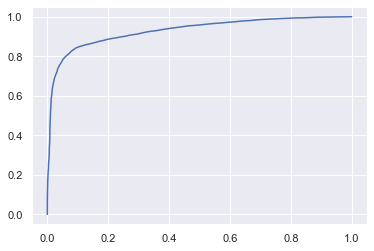

In [28]:
plt.plot(fpr,tpr)

In [29]:
auc(label,p[:,1])

86.70500000000001